# Deep Learning Reversal Prediction (LSTM Version)

This notebook is a **corrected deep learning version** of your reversal model.

### Key features:
- Uses **PyTorch LSTM** instead of XGBoost/LightGBM.
- Configurable **window size** (sliding sequence length).
- Same feature engineering (EMA, MACD, RSI, etc.) and labeling (forward & pivot).
- Handles **class imbalance** with weighted loss.
- Saves trained model + metadata.


In [1]:

import os, glob, warnings, math
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:

# Load CSV automatically (choose your dataset file)
def find_csv():
    candidates = glob.glob('*.csv')
    if not candidates:
        return None
    return sorted(candidates, key=lambda p: os.path.getsize(p), reverse=True)[0]

csv_file = find_csv()
if csv_file is None:
    raise FileNotFoundError("No CSV found in working dir. Upload your crypto dataset.")
print("Using CSV:", csv_file)

df = pd.read_csv(csv_file)

# normalize column names
colmap = {}
for c in df.columns:
    cl = c.lower()
    if cl in ['date','timestamp','time']:
        colmap[c] = 'timestamp'
    if cl in ['close','close_price','adj_close']:
        colmap[c] = 'close'
    if cl == 'open':
        colmap[c] = 'open'
    if cl == 'high':
        colmap[c] = 'high'
    if cl == 'low':
        colmap[c] = 'low'
    if 'volume' in cl:
        colmap[c] = 'volume'
df = df.rename(columns=colmap)
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
df = df[[c for c in ['timestamp','open','high','low','close','volume'] if c in df.columns]]
df = df.dropna().reset_index(drop=True)
print("Data shape:", df.shape)
display(df.head())


Using CSV: btc_master_indicators.csv
Data shape: (983, 6)


,timestamp,open,high,low,close,volume
0,2025-08-16 13:00:00,117747.35,117799.99,117582.29,117623.52,365.37584
1,2025-08-16 14:00:00,117623.53,117771.40,117550.00,117771.39,253.05868
2,2025-08-16 15:00:00,117771.40,117825.00,117621.10,117676.70,224.96201
3,2025-08-16 16:00:00,117676.70,117817.65,117676.70,117747.65,389.81984
4,2025-08-16 17:00:00,117747.64,117747.65,117651.72,117693.00,181.46105


In [3]:

# Feature engineering
def compute_features(df):
    df = df.copy()
    df['return_1'] = df['close'].pct_change()
    df['ema_8'] = df['close'].ewm(span=8).mean()
    df['ema_21'] = df['close'].ewm(span=21).mean()
    df['ma_50'] = df['close'].rolling(50).mean()
    df['std_20'] = df['close'].rolling(20).std()
    df['bb_upper'] = df['ma_50'] + 2*df['std_20']
    df['bb_lower'] = df['ma_50'] - 2*df['std_20']
    delta = df['close'].diff()
    up, down = delta.clip(lower=0), -1*delta.clip(upper=0)
    ema_up, ema_down = up.ewm(com=13).mean(), down.ewm(com=13).mean()
    rs = ema_up/ema_down.replace(0, np.nan)
    df['rsi_14'] = 100 - (100/(1+rs))
    ema12 = df['close'].ewm(span=12).mean()
    ema26 = df['close'].ewm(span=26).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    if {'high','low','close'}.issubset(df.columns):
        df['tr'] = df[['high','low','close']].apply(lambda x: max(x['high']-x['low'], abs(x['high']-x['close']), abs(x['low']-x['close'])), axis=1)
        df['atr_14'] = df['tr'].rolling(14).mean()
    for lag in [1,2,3,5,8,13]:
        df[f'close_lag_{lag}'] = df['close'].shift(lag)
        df[f'return_lag_{lag}'] = df['close'].pct_change(lag)
    df = df.fillna(method='bfill').fillna(0)
    return df

df = compute_features(df)
print("Features:", len(df.columns))
display(df.tail(3).T)


Features: 30


,980,981,982
timestamp,2025-09-26 09:00:00,2025-09-26 10:00:00,2025-09-26 11:00:00
open,109567.2,109568.72,108894.99
high,109690.98,109568.72,108950.68
low,109393.37,108697.42,108620.07
close,109568.72,108895.0,108743.94
volume,441.33309,735.10273,530.66205
return_1,0.000014,-0.006149,-0.001387
ema_8,109481.213182,109350.943586,109216.0539
ema_21,109909.543784,109817.312531,109719.73321
ma_50,111449.7548,111375.1988,111295.3764


In [4]:

# Labeling methods
LOOKAHEAD = 24
UP_THRESHOLD = 0.01
DOWN_THRESHOLD = 0.01

def label_forward(df, lookahead=LOOKAHEAD, up_thr=UP_THRESHOLD, down_thr=DOWN_THRESHOLD):
    close = df['close'].values
    n = len(close)
    label = np.zeros(n, dtype=int)
    for i in range(n):
        end = min(n, i+lookahead+1)
        future = close[i+1:end]
        if len(future)==0: continue
        if np.max(future) >= close[i]*(1+up_thr): label[i]=1
        elif np.min(future) <= close[i]*(1-down_thr): label[i]=1
    df['label_forward'] = label
    return df

def label_pivot(df, window=5):
    close = df['close']
    n = len(close)
    label = np.zeros(n, dtype=int)
    for i in range(n):
        left, right = max(0,i-window), min(n,i+window+1)
        if close.iloc[i] == close.iloc[left:right].min(): label[i]=1
        if close.iloc[i] == close.iloc[left:right].max(): label[i]=1
    df['label_pivot'] = label
    return df

df = label_forward(df)
df = label_pivot(df)
print("Forward label distribution:", df['label_forward'].value_counts().to_dict())
print("Pivot label distribution:", df['label_pivot'].value_counts().to_dict())


Forward label distribution: {1: 696, 0: 287}
Pivot label distribution: {0: 857, 1: 126}


In [5]:

# Prepare dataset for LSTM
LABEL_METHOD = 'forward'  # 'forward' or 'pivot'
WINDOW_SIZE = 30          # configurable

features = [c for c in df.columns if c not in ['timestamp','label_forward','label_pivot']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

if LABEL_METHOD == 'forward':
    y = df['label_forward'].values
else:
    y = df['label_pivot'].values

class SequenceDataset(Dataset):
    def __init__(self, X, y, window):
        self.X, self.y, self.window = X, y, window
    def __len__(self):
        return len(self.X) - self.window
    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx:idx+self.window], dtype=torch.float32),
            torch.tensor(self.y[idx+self.window], dtype=torch.long)
        )

split = int(len(X_scaled)*0.8)
train_ds = SequenceDataset(X_scaled[:split], y[:split], WINDOW_SIZE)
test_ds  = SequenceDataset(X_scaled[split:], y[split:], WINDOW_SIZE)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=64)
print("Train sequences:", len(train_ds), "Test sequences:", len(test_ds))


Train sequences: 756 Test sequences: 167


In [6]:

# Define LSTM model
class CryptoLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:,-1,:])

input_dim = X_scaled.shape[1]
model = CryptoLSTM(input_dim)
print(model)


CryptoLSTM(
  (lstm): LSTM(29, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [7]:

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# handle imbalance
class_counts = np.bincount(y)
weights = torch.tensor([len(y)/c if c>0 else 1.0 for c in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss=0
    for xb,yb in train_dl:
        xb,yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out,yb)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - loss {total_loss/len(train_dl):.4f}")


Epoch 1/10 - loss 0.6803
Epoch 2/10 - loss 0.6558
Epoch 3/10 - loss 0.6140
Epoch 4/10 - loss 0.5637
Epoch 5/10 - loss 0.5195
Epoch 6/10 - loss 0.4761
Epoch 7/10 - loss 0.4771
Epoch 8/10 - loss 0.4393
Epoch 9/10 - loss 0.4317
Epoch 10/10 - loss 0.3934


In [8]:

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb,yb in test_dl:
        xb,yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = out.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.cpu().numpy())

print(classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

           0     0.9615    0.3247    0.4854        77
           1     0.6312    0.9889    0.7706        90

    accuracy                         0.6826       167
   macro avg     0.7964    0.6568    0.6280       167
weighted avg     0.7835    0.6826    0.6391       167

Confusion matrix:
 [[25 52]
 [ 1 89]]


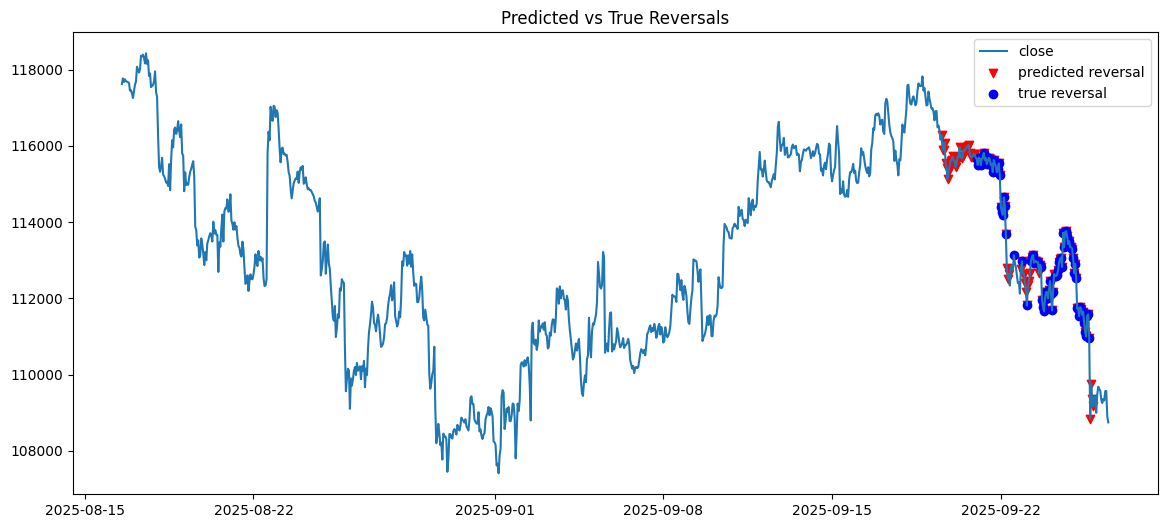

In [9]:

# Plot predicted reversals
test_index = range(split+WINDOW_SIZE, len(df))
pred_series = pd.Series(y_pred, index=test_index)
df_test = df.iloc[test_index].copy()
df_test['pred_label'] = pred_series

plt.figure(figsize=(14,6))
plt.plot(df['timestamp'], df['close'], label='close')
pred_points = df_test[df_test['pred_label']==1]
plt.scatter(pred_points['timestamp'], pred_points['close'], marker='v', c='red', label='predicted reversal')
true_points = df_test[df_test['label_forward' if LABEL_METHOD=='forward' else 'label_pivot']==1]
plt.scatter(true_points['timestamp'], true_points['close'], marker='o', c='blue', label='true reversal')
plt.legend(); plt.title("Predicted vs True Reversals"); plt.show()


In [10]:

# Save model + metadata
torch.save(model.state_dict(), "lstm_reversal_model.pth")
meta = dict(features=features, window=WINDOW_SIZE, label_method=LABEL_METHOD)
with open("reversal_metadata_LSTM.json","w") as f: json.dump(meta,f)
print("Saved lstm_reversal_model.pth and metadata.")


NameError: name 'json' is not defined